# Mean Variance Estimation

## Imports

In [ ]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

: 

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, Y_train, train_loader, X_test, Y_test, test_loader, X_gtext, Y_gtext = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
    dm.X_gtext,
    dm.Y_gtext,
)

In [5]:
import numpy as np
n_points = 250
x_min = -2
x_max = 4

In [6]:

x = np.empty(n_points)
y = np.empty(n_points)
for k in range(n_points):
    rnd = np.random.rand()
    if rnd < 1 / 3.0:
        x[k] = np.random.normal(loc=x_min, scale=2.0 / 5.0)
    else:
        if rnd < 2.0 / 3.0:
            x[k] = np.random.normal(loc=0.0, scale=0.9)
        else:
            x[k] = np.random.normal(loc=x_max, scale=2.0 / 5.0)

In [7]:
x.min()

-2.8380630090719943

In [8]:
dm.X_all.min()

tensor(-5.2965)

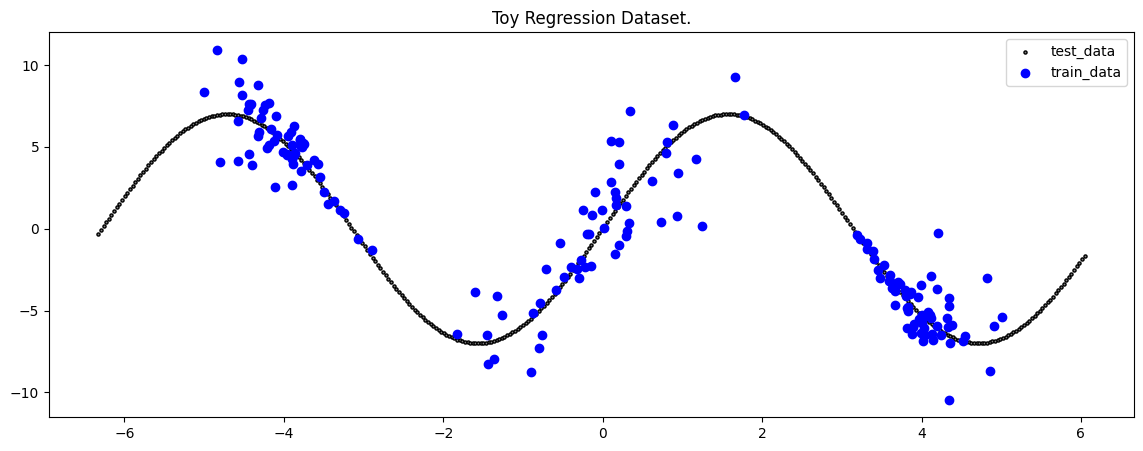

In [9]:
fig = plot_toy_regression_data(X_train, Y_train, X_gtext, Y_gtext)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [21]:
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=2, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible. 

We can first train with the MSE loss, and only adapt the parameters of the mean prediction for the number of ```burnin_eochs``` for more stable training, before switching to the NLL loss. 

In [31]:
mve_model = MVERegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-3), burnin_epochs=5
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [49]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    accelerator="gpu",  # use distributed training
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience = 10)]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [50]:
trainer.fit(mve_model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 5.4 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | loss_fn       | DERLoss          | 0      | train
5 | der_layer     | DERLayer         | 0      | train
-----------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/groups/ai/buelte/anaconda3/envs/kernel-entropies/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

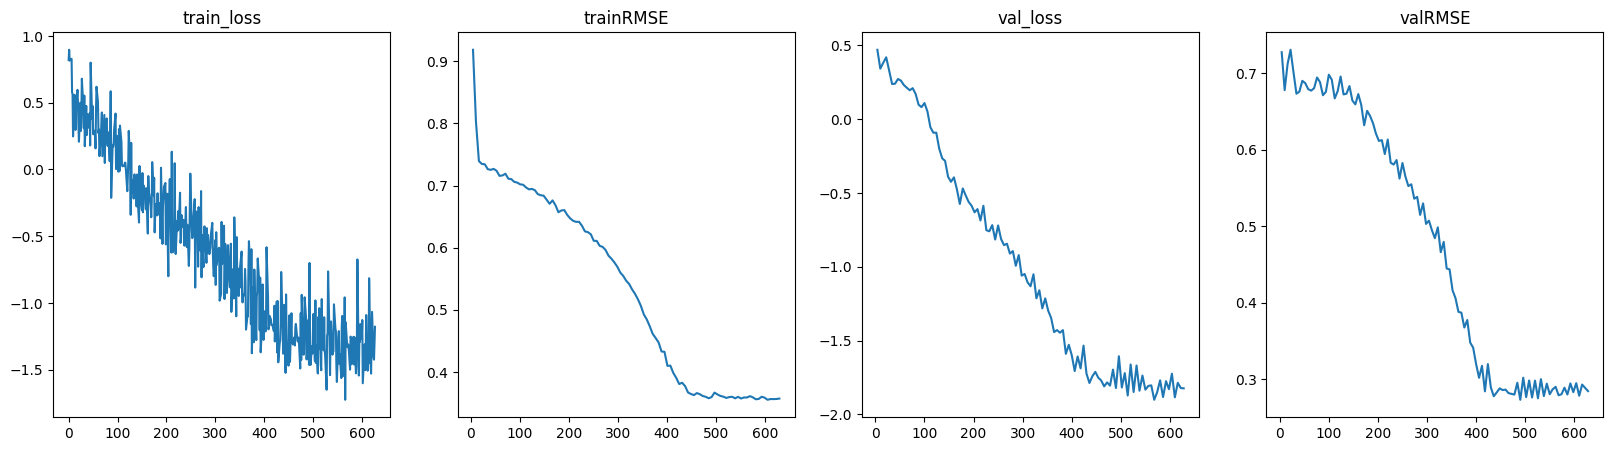

In [51]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE", "val_loss", "valRMSE"]
)

## Evaluate Predictions

The constructed Data Module contains two possible test variable. `X_test` are IID samples from the same noise distribution as the training data, while `X_gtext` ("X ground truth extended") are dense inputs from the underlying "ground truth" function without any noise that also extends the input range to either side, so we can visualize the method's UQ tendencies when extrapolating beyond the training data range. Thus, we will use `X_gtext` for visualization purposes, but use `X_test` to compute uncertainty and calibration metrics because we want to analyse how well the method has learned the noisy data distribution.

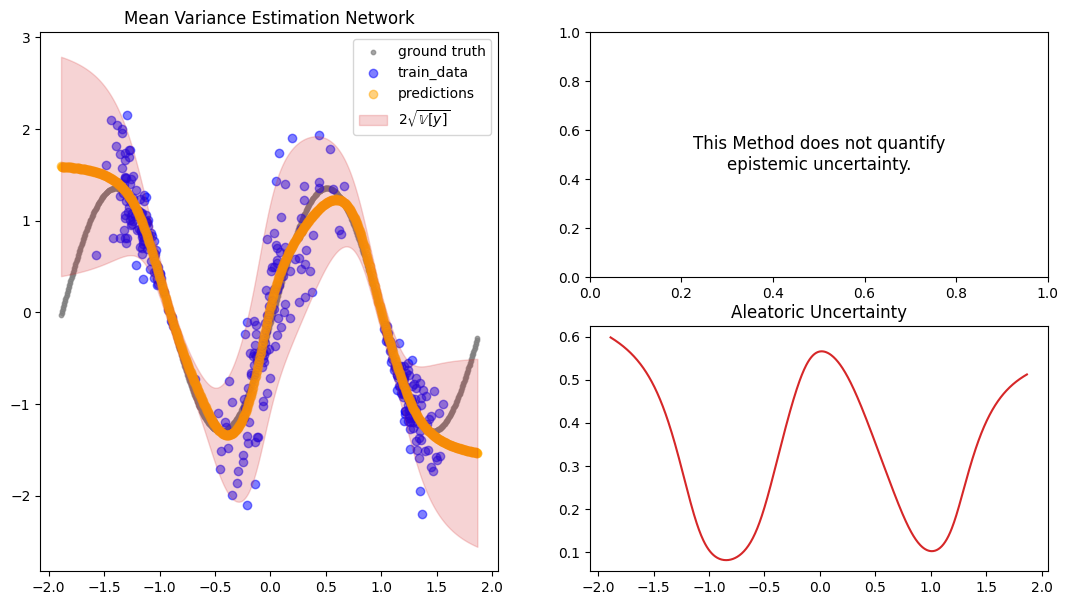

In [43]:
preds = mve_model.predict_step(X_gtext)

fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_gtext,
    Y_gtext,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    aleatoric=preds["aleatoric_uct"],
    title="Mean Variance Estimation Network",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction, that we can evaluate on our held out IID test set.

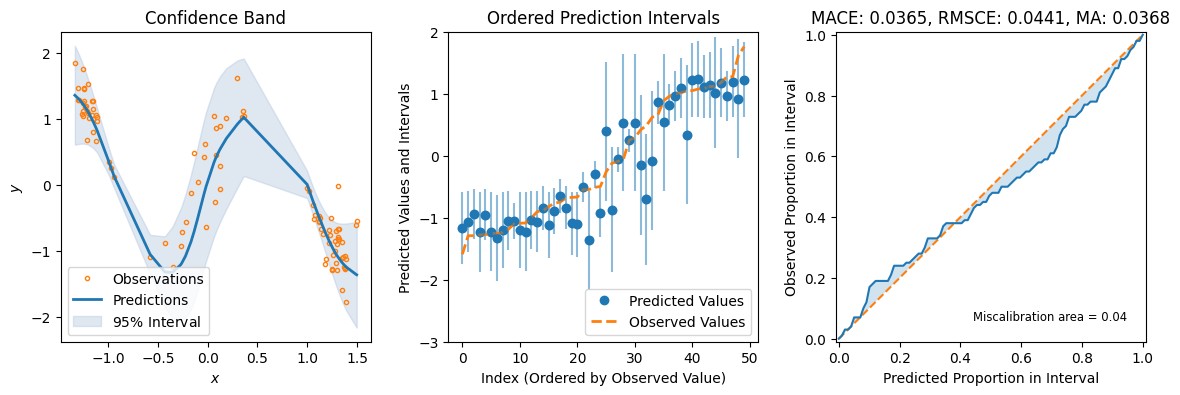

In [44]:
preds = mve_model.predict_step(X_test)

fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    Y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)